Total number of audio files: 1440

Number of samples by emotion category:
emotion_category
Negative    768
Positive    384
Neutral     288
Name: count, dtype: int64

Number of samples by emotion category:
emotion_code
Angry        192
Fearful      192
Disgust      192
Sad          192
Surprised    192
Happy        192
Calm         192
Neutral       96
Name: count, dtype: int64


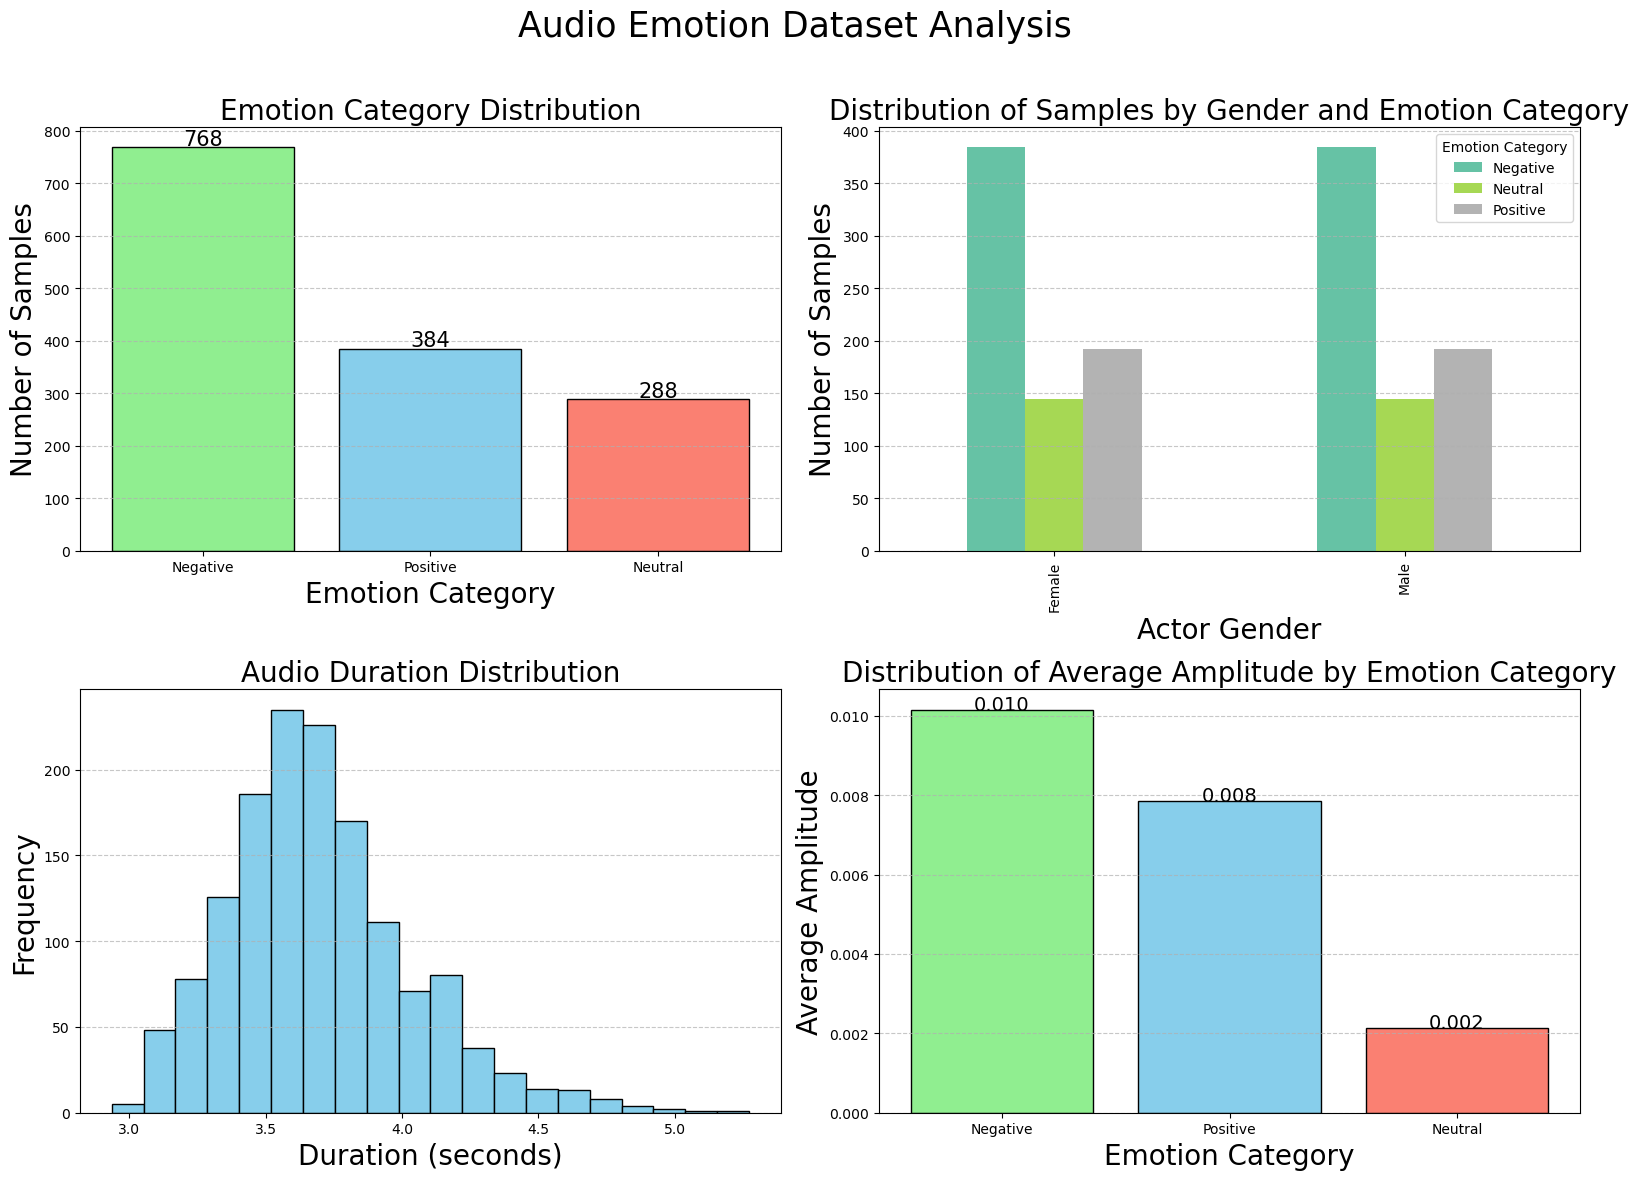

In [63]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File Directory
folder_path = '../dataset'

# Obtain all wav file paths
wav_files = []
for root, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.wav'):
            wav_files.append(os.path.join(root, file))

# Create an empty list to store data
audio_data = []

for file in wav_files:
    file_name = os.path.basename(file)
    
    # Parse file name
    parts = file_name.split('-')
    if len(parts) >= 7:  # Ensure the file name format is correct
        modality = parts[0]  # 01=full-AV, 02=video-only, 03=audio-only
        vocal_channel = parts[1]  # 01=speech, 02=song
        emotion_code = parts[2]  # Emotion code
        
        # Only keep audio-only and speech data
        if modality == '03' and vocal_channel == '01':
            y, sr = librosa.load(file, sr=None)  # Read audio data
            duration = librosa.get_duration(y=y, sr=sr)  # Get duration
            audio_data.append({
                'file_name': file_name,
                'sampling_rate': sr,
                'duration_sec': duration,
                'mean_amplitude': np.mean(np.abs(y)),
                'max_amplitude': np.max(np.abs(y)),
                'modality': modality,
                'vocal_channel': vocal_channel,
                'emotion_code': emotion_code,
                'intensity': parts[3],
                'statement': parts[4],
                'repetition': parts[5],
                'actor': parts[6].split('.')[0]  # Remove file extension
            })

# Convert data to DataFrame
audio_df = pd.DataFrame(audio_data)

# Define emotion classification mapping (according to the requirements) 
emotion_mapping = {
    '01': 'Neutral',  # neutral
    '02': 'Neutral',  # calm
    '03': 'Positive',  # happy
    '08': 'Positive',  # surprised
    '04': 'Negative',  # sad
    '05': 'Negative',  # angry
    '06': 'Negative',  # fearful
    '07': 'Negative'   # disgust
}

# Map to emotion category   
audio_df['emotion_category'] = audio_df['emotion_code'].map(emotion_mapping)

# Add actor gender information
audio_df['actor_gender'] = audio_df['actor'].apply(lambda x: 'Female' if int(x) % 2 == 0 else 'Male')

# Basic information of the dataset
print(f"Total number of audio files: {len(audio_df)}")
print("\nNumber of samples by emotion category:")
emotion_counts = audio_df['emotion_category'].value_counts()
print(emotion_counts)

print("\nNumber of samples by emotion category:")
emotion_detailed = audio_df['emotion_code'].map({
    '01': 'Neutral', '02': 'Calm', '03': 'Happy', 
    '04': 'Sad', '05': 'Angry', '06': 'Fearful', 
    '07': 'Disgust', '08': 'Surprised'
}).value_counts()
print(emotion_detailed)

# Create a 2x2 subplot figure instead of separate figures
plt.figure(figsize=(16, 12))

# 1. Plot the bar chart of emotion category distribution - Top left (1,1)
plt.subplot(2, 2, 1)
bars = plt.bar(emotion_counts.index, emotion_counts.values, 
         color=['lightgreen', 'skyblue', 'salmon'], edgecolor='black')

# Add number annotation  
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(bar.get_height()), ha='center', fontsize=15)

plt.title('Emotion Category Distribution', fontsize=20)
plt.xlabel('Emotion Category', fontsize=20)
plt.ylabel('Number of Samples', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Analyze data by gender and emotion category - Top right (1,2)
plt.subplot(2, 2, 2)
gender_emotion = pd.crosstab(audio_df['actor_gender'], audio_df['emotion_category'])
gender_emotion.plot(kind='bar', ax=plt.gca(), colormap='Set2')
plt.title('Distribution of Samples by Gender and Emotion Category', fontsize=20)
plt.xlabel('Actor Gender', fontsize=20)
plt.ylabel('Number of Samples', fontsize=20)
plt.legend(title='Emotion Category')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Analyze audio duration - Bottom left (2,1)
plt.subplot(2, 2, 3)
plt.hist(audio_df['duration_sec'], bins=20, color='skyblue', edgecolor='black')
plt.title('Audio Duration Distribution', fontsize=20)
plt.xlabel('Duration (seconds)', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Average amplitude of each emotion - Bottom right (2,2)
plt.subplot(2, 2, 4)
avg_amplitude = audio_df.groupby('emotion_category')['mean_amplitude'].mean().sort_values(ascending=False)
bars = plt.bar(avg_amplitude.index, avg_amplitude.values, 
         color=['lightgreen', 'skyblue', 'salmon'], edgecolor='black')

# Add number annotation
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f"{bar.get_height():.3f}", ha='center', fontsize=14)

plt.title('Distribution of Average Amplitude by Emotion Category', fontsize=20)
plt.xlabel('Emotion Category', fontsize=20)
plt.ylabel('Average Amplitude', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a main title and adjust layout
plt.suptitle('Audio Emotion Dataset Analysis', fontsize=25, y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the main title
plt.show()

## Sampling Strategy

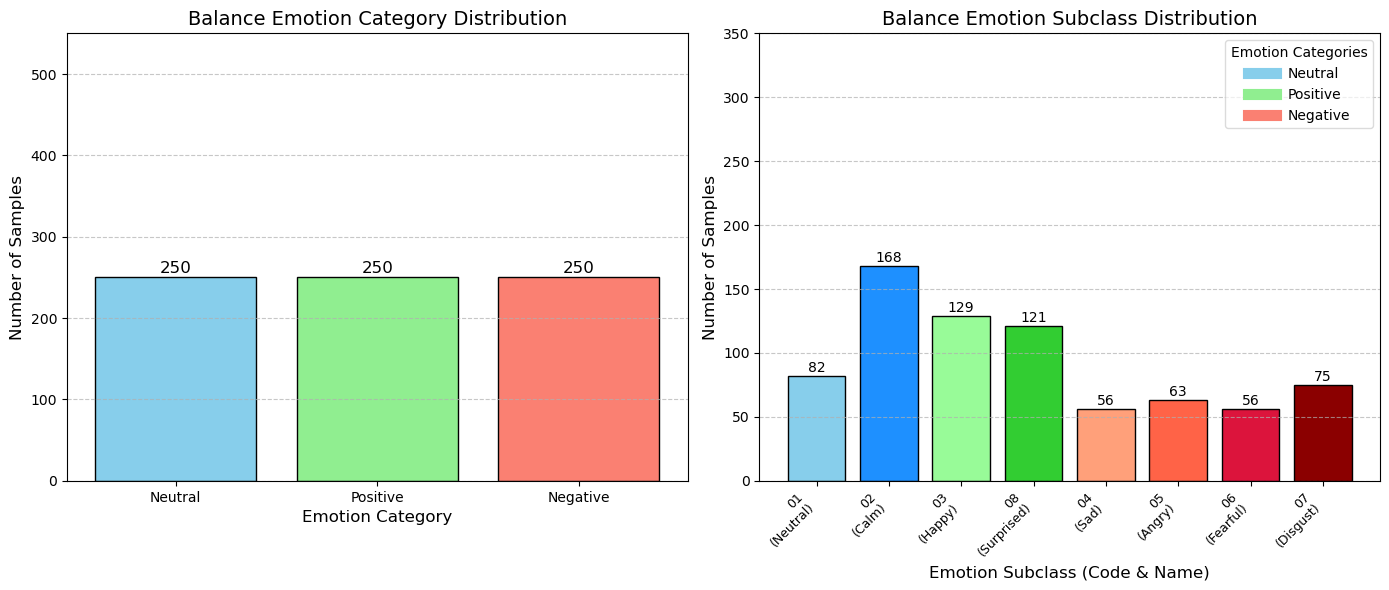

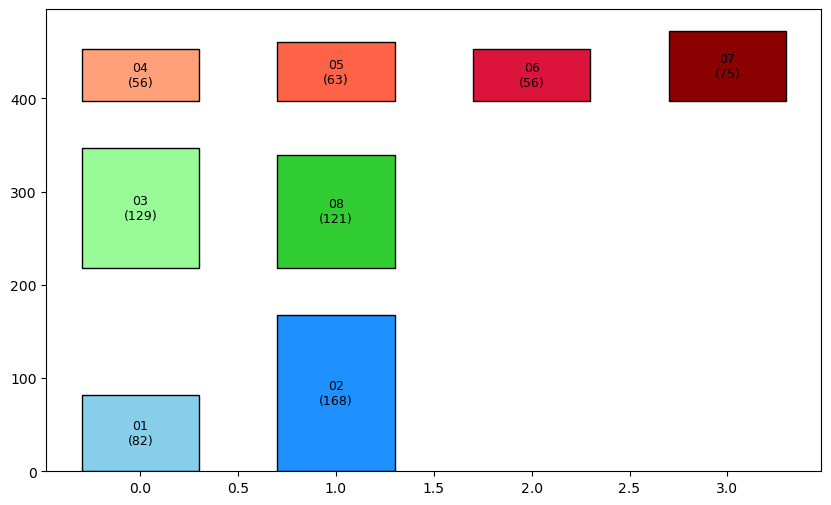

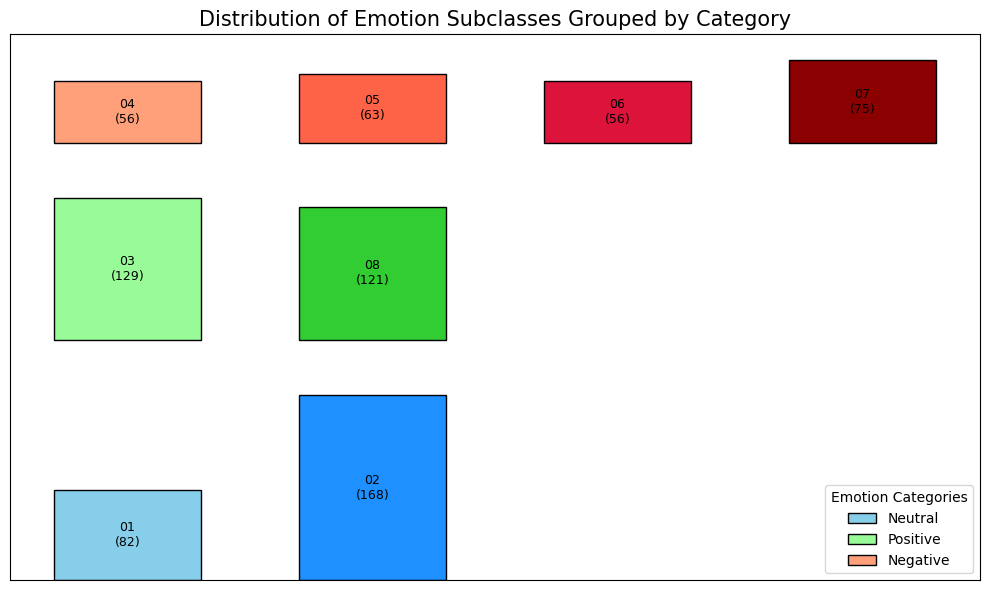

In [43]:
# Visualize the balanced emotion distribution 
plt.figure(figsize=(14, 6))

# Define basic colors for the main categories
category_colors = {
    'Neutral': 'skyblue',
    'Positive': 'lightgreen',
    'Negative': 'salmon'
}

# Assign similar tone colors to each subclass (maintain consistency with the parent class)
subclass_colors = {
    # Neutral class (blue系)
    '01': '#87CEEB',  # light blue - Neutral
    '02': '#1E90FF',  # dark blue - Calm
    
    # Positive class (green系)
    '03': '#98FB98',  # light green - Happy
    '08': '#32CD32',  # dark green - Surprised
    
    # Negative class (red系)
    '04': '#FFA07A',  # light orange red - Sad
    '05': '#FF6347',  # medium red - Angry
    '06': '#DC143C',  # dark red - Fearful
    '07': '#8B0000'   # dark red - Disgust
}

# Create a mapping from emotion code to category
code_to_category = {}
for code, category in emotion_mapping.items():
    code_to_category[code] = category

# Plot the distribution of main categories  
plt.subplot(1, 2, 1)
category_order = ['Neutral', 'Positive', 'Negative']  # Ensure consistency
category_values = [balanced_emotion_counts.get(cat, 0) for cat in category_order]
category_colors_list = [category_colors[cat] for cat in category_order]

bars = plt.bar(category_order, category_values, color=category_colors_list, edgecolor='black')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(int(bar.get_height())), ha='center', fontsize=12)

plt.title('Balance Emotion Category Distribution', fontsize=14)
plt.xlabel('Emotion Category', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 550)  # Set the y-axis upper limit, leave space for labels

# Plot the subclass distribution
plt.subplot(1, 2, 2)

# Sort the subclass codes by emotion category
subclass_order = sorted(balanced_subclass_counts.index, 
                        key=lambda x: (list(category_colors.keys()).index(code_to_category.get(x, '')), x))
subclass_values = [balanced_subclass_counts.get(code, 0) for code in subclass_order]
subclass_colors_list = [subclass_colors.get(code, 'gray') for code in subclass_order]

bars = plt.bar(subclass_order, subclass_values, color=subclass_colors_list, edgecolor='black')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
             str(int(bar.get_height())), ha='center', fontsize=10)

# Add emotion name labels to the subclass
emotion_names = {
    '01': 'Neutral', '02': 'Calm', '03': 'Happy', '04': 'Sad',
    '05': 'Angry', '06': 'Fearful', '07': 'Disgust', '08': 'Surprised'
}

# Create custom x-axis labels (emotion code + name)
plt.xticks(range(len(subclass_order)), 
           [f"{code}\n({emotion_names.get(code, '')})" for code in subclass_order],
           rotation=45, ha='right', fontsize=9)

plt.title('Balance Emotion Subclass Distribution', fontsize=14)
plt.xlabel('Emotion Subclass (Code & Name)', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 350)  # Set the y-axis upper limit, leave space for labels

# Add legend, showing the color correspondence between main categories and subclasses
legend_elements = []
for category, color in category_colors.items():
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=8, label=f'{category}'))
plt.legend(handles=legend_elements, title='Emotion Categories', 
           loc='upper right', framealpha=0.7)

plt.tight_layout()
plt.show()

# In order to more clearly display the relationship between subclasses and main categories, add an additional chart
plt.figure(figsize=(10, 6))
# Prepare data
category_data = {}
for code in subclass_order:
    category = code_to_category.get(code, '')
    if category not in category_data:
        category_data[category] = []
    category_data[category].append((code, balanced_subclass_counts.get(code, 0)))

# Create a stacked bar chart
bottom = 0
bar_width = 0.6
for i, (category, data) in enumerate(category_data.items()):
    codes, counts = zip(*data)
    positions = range(len(codes))
    colors = [subclass_colors.get(code, 'gray') for code in codes]
    
    plt.bar(positions, counts, bottom=bottom, color=colors, width=bar_width, 
            edgecolor='black', label=category)
    
    # Add labels
    for j, count in enumerate(counts):
        plt.text(positions[j], bottom + count/2, f"{codes[j]}\n({count})", 
                 ha='center', va='center', fontsize=9, color='black')
    
    bottom += max(counts) + 50  # Add interval
plt.figure(figsize=(10, 6))
# Prepare data  
category_data = {}
for code in subclass_order:
    category = code_to_category.get(code, '')
    if category not in category_data:
        category_data[category] = []
    category_data[category].append((code, balanced_subclass_counts.get(code, 0)))

# Create a stacked bar chart
bottom = 0
bar_width = 0.6
for i, (category, data) in enumerate(category_data.items()):
    codes, counts = zip(*data)
    positions = range(len(codes))
    colors = [subclass_colors.get(code, 'gray') for code in codes]
    
    plt.bar(positions, counts, bottom=bottom, color=colors, width=bar_width, 
            edgecolor='black', label=category)
    
    # 添加标签
    for j, count in enumerate(counts):
        plt.text(positions[j], bottom + count/2, f"{codes[j]}\n({count})", 
                 ha='center', va='center', fontsize=9, color='black')
    
    bottom += max(counts) + 50  # 添加间隔

plt.title('Distribution of Emotion Subclasses Grouped by Category', fontsize=20)
plt.ylabel('')  # Remove the y-axis label
plt.xticks([])  # Remove the x-axis ticks
plt.yticks([])  # Remove the y-axis ticks
plt.grid(False)  # Remove the grid lines
plt.legend(title='Emotion Categories')
plt.tight_layout()
plt.show()

## Data Sampling

In [46]:
import os
import shutil
import numpy as np
import pandas as pd

# Use the correct dataset path
dataset_path = '../dataset'
print(f"Use the dataset path: {dataset_path}")

# Check if the path exists
if not os.path.exists(dataset_path):
    print(f"Error: The path {dataset_path} does not exist!")
    exit(1)

# Traverse all files in the dataset
audio_files = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith('.wav'):
            full_path = os.path.join(root, file)
            audio_files.append(full_path)

print(f"Found {len(audio_files)} audio files")

# Check the file naming format, extract emotion information
audio_data = []
for file_path in audio_files:
    filename = os.path.basename(file_path)
    parts = filename.split('-')
    
    if len(parts) >= 3:
        try:
            modality = parts[0]
            vocal_channel = parts[1]
            emotion_code = parts[2]
            
            # Only process data with audio mode 03 (audio-only) and speech channel 01 (speech)
            if modality == '03' and vocal_channel == '01':
                # Map emotion code to category
                if emotion_code in ['03', '08']: # Happy, surprised
                    emotion_category = 'Positive'
                elif emotion_code in ['01', '02']: # Neutral, calm
                    emotion_category = 'Neutral'
                elif emotion_code in ['04', '05', '06', '07']: # Sad, angry, fearful, disgust
                    emotion_category = 'Negative'
                else:
                    continue  # Skip the emotion code that cannot be identified
                
                # Save the processing results
                audio_data.append({
                    'file_path': file_path,
                    'file_name': filename,
                    'emotion_code': emotion_code,
                    'emotion_category': emotion_category,
                    'intensity': parts[3] if len(parts) > 3 else '',
                    'statement': parts[4] if len(parts) > 4 else '',
                    'repetition': parts[5] if len(parts) > 5 else '',
                    'actor': parts[6].split('.')[0] if len(parts) > 6 else ''
                })
                
        except Exception as e:
            print(f"Error parsing file {filename}: {str(e)}")
            continue

# Create a data frame
audio_df = pd.DataFrame(audio_data)

# Check if the data frame is empty
if len(audio_df) == 0:
    print("Warning: No audio files found that meet the conditions! Please check the file naming format and path.")
    exit(1)

print(f"\nThe processed dataset contains {len(audio_df)} files")
print("Emotion category distribution:")
print(audio_df['emotion_category'].value_counts())

# Perform emotion category balanced sampling (250 samples per category)
# Modify: Reduce the target sample number from 500 to 250
target_per_category = 250
balanced_df = pd.DataFrame()
for category in ['Positive', 'Negative', 'Neutral']:
    category_df = audio_df[audio_df['emotion_category'] == category]
    
    if len(category_df) > 0:
        # If the category has less than 250 samples, keep all and oversample to 250
        if len(category_df) < target_per_category:
            print(f"{category} has less than 250 samples, oversample from {len(category_df)} to {target_per_category}")
            oversampled = category_df.sample(n=target_per_category, replace=True, random_state=42)
            balanced_df = pd.concat([balanced_df, oversampled])
        else:
            # If the category has more than 250 samples, randomly sample 250
            print(f"{category} has more than 250 samples, sample {target_per_category} from {len(category_df)}")
            sampled = category_df.sample(n=target_per_category, random_state=42)
            balanced_df = pd.concat([balanced_df, sampled])

# Check the balanced data frame
print("\nThe size of the balanced dataset:", len(balanced_df))
print("The emotion category distribution of the balanced dataset:")
print(balanced_df['emotion_category'].value_counts())

# Calculate the distribution of each subclass
balanced_subclass_counts = balanced_df['emotion_code'].value_counts()
print("\nThe emotion subclass distribution of the balanced dataset:")
for code, count in balanced_subclass_counts.items():
    emotion_name = {
        '01': 'Neutral', '02': 'Calm', '03': 'Happy', 
        '04': 'Sad', '05': 'Angry', '06': 'Fearful', 
        '07': 'Disgust', '08': 'Surprised'
    }.get(code, code)
    print(f"  {code} ({emotion_name}): {count}")

# Create the output directory structure
output_base_dir = './processed_audio_data'
os.makedirs(output_base_dir, exist_ok=True)

# Create a subfolder for each emotion category
for category in ['Positive', 'Negative', 'Neutral']:
    category_dir = os.path.join(output_base_dir, category.lower())
    os.makedirs(category_dir, exist_ok=True)
    print(f"Create directory: {category_dir}")

# Copy files to the corresponding emotion category folder
files_copied = {'Positive': 0, 'Negative': 0, 'Neutral': 0}
files_not_found = []

print("\nStart copying files to the corresponding emotion category folder...")

for index, row in balanced_df.iterrows():
    source_file = row['file_path']
    
    if os.path.exists(source_file):
        # Determine the target folder (based on the emotion category)
        emotion_category = row['emotion_category']
        dest_dir = os.path.join(output_base_dir, emotion_category.lower())
        
        # Build the target file path
        dest_file = os.path.join(dest_dir, os.path.basename(source_file))
        
        # Copy the file
        shutil.copy2(source_file, dest_file)
        files_copied[emotion_category] += 1
        
        # Print the progress every 50 files copied
        total_copied = sum(files_copied.values())
        if total_copied % 50 == 0:
            print(f"Copied {total_copied}/{len(balanced_df)} files...")
    else:
        files_not_found.append(source_file)

print("\nFile copying completed!")
print("\nThe number of files in each emotion category:")
for category, count in files_copied.items():
    print(f"{category}: {count} files")

if files_not_found:
    print(f"\nWarning: {len(files_not_found)} files not found")
    if len(files_not_found) <= 10:
        print("Files not found:", files_not_found)
    else:
        print("The first 10 files not found:", files_not_found[:10])

# 创建一个元数据文件
metadata_file = os.path.join(output_base_dir, 'metadata.txt')
with open(metadata_file, 'w') as f:
    f.write("Balance dataset metadata\n")
    f.write("====================\n\n")
    f.write(f"Total number of files: {len(balanced_df)}\n\n")
    
    f.write("The number of files in each emotion category:\n")
    for category, count in files_copied.items():
        f.write(f"{category}: {count}\n")
    
    f.write("\nThe subclass distribution in each emotion category:\n")
    for category in ['Positive', 'Negative', 'Neutral']:
        f.write(f"\n{category} subclass distribution:\n")
        
        # Get the subclass distribution in this category
        category_df = balanced_df[balanced_df['emotion_category'] == category]
        subcategory_counts = category_df['emotion_code'].value_counts()
        
        for code, count in subcategory_counts.items():
            emotion_name = {
                '01': 'Neutral', '02': 'Calm', '03': 'Happy', 
                '04': 'Sad', '05': 'Angry', '06': 'Fearful', 
                '07': 'Disgust', '08': 'Surprised'
            }.get(code, code)
            f.write(f"  {code} ({emotion_name}): {count}\n")

print(f"\nMetadata has been saved to {metadata_file}")

csv_output = os.path.join(output_base_dir, 'balanced_dataset_files.csv')
balanced_df[['file_name', 'emotion_code', 'emotion_category']].to_csv(csv_output, index=False)
print(f"已输出文件清单到 {csv_output}")

# Define the mapping from emotion code to category, for visualization
emotion_mapping = {}
for code in ['01', '02']:
    emotion_mapping[code] = 'Neutral'
for code in ['03', '08']:
    emotion_mapping[code] = 'Positive'
for code in ['04', '05', '06', '07']:
    emotion_mapping[code] = 'Negative'

# Calculate the count of each emotion category after balancing
balanced_emotion_counts = balanced_df['emotion_category'].value_counts()

print("\nData processing completed! Files have been classified by emotion category and output, 250 samples per category.")

Use the dataset path: ../dataset
Found 1440 audio files

The processed dataset contains 1440 files
Emotion category distribution:
emotion_category
Negative    768
Positive    384
Neutral     288
Name: count, dtype: int64
Positive has more than 250 samples, sample 250 from 384
Negative has more than 250 samples, sample 250 from 768
Neutral has more than 250 samples, sample 250 from 288

The size of the balanced dataset: 750
The emotion category distribution of the balanced dataset:
emotion_category
Positive    250
Negative    250
Neutral     250
Name: count, dtype: int64

The emotion subclass distribution of the balanced dataset:
  02 (Calm): 168
  03 (Happy): 129
  08 (Surprised): 121
  01 (Neutral): 82
  07 (Disgust): 75
  05 (Angry): 63
  04 (Sad): 56
  06 (Fearful): 56
Create directory: ./processed_audio_data/positive
Create directory: ./processed_audio_data/negative
Create directory: ./processed_audio_data/neutral

Start copying files to the corresponding emotion category folder...

## Experiment Dataset Split

Created directory: ./experiment_data/experiment_positive
Created directory: ./experiment_data/experiment_neutral
Created directory: ./experiment_data/experiment_negative
Found 250 files in Positive category
Found 250 files in Neutral category
Found 250 files in Negative category
Positive category has fewer than 250 files, using all 250 files


Copying Positive files: 100%|██████████| 250/250 [00:00<00:00, 538.00it/s]


Neutral category has fewer than 250 files, using all 250 files


Copying Neutral files: 100%|██████████| 250/250 [00:00<00:00, 795.41it/s]


Negative category has fewer than 250 files, using all 250 files


Copying Negative files: 100%|██████████| 250/250 [00:00<00:00, 824.47it/s]



Sampling complete. Files copied per category:
Positive: 250/250
Neutral: 250/250
Negative: 250/250

Metadata saved to ./experiment_data/experiment_metadata.txt


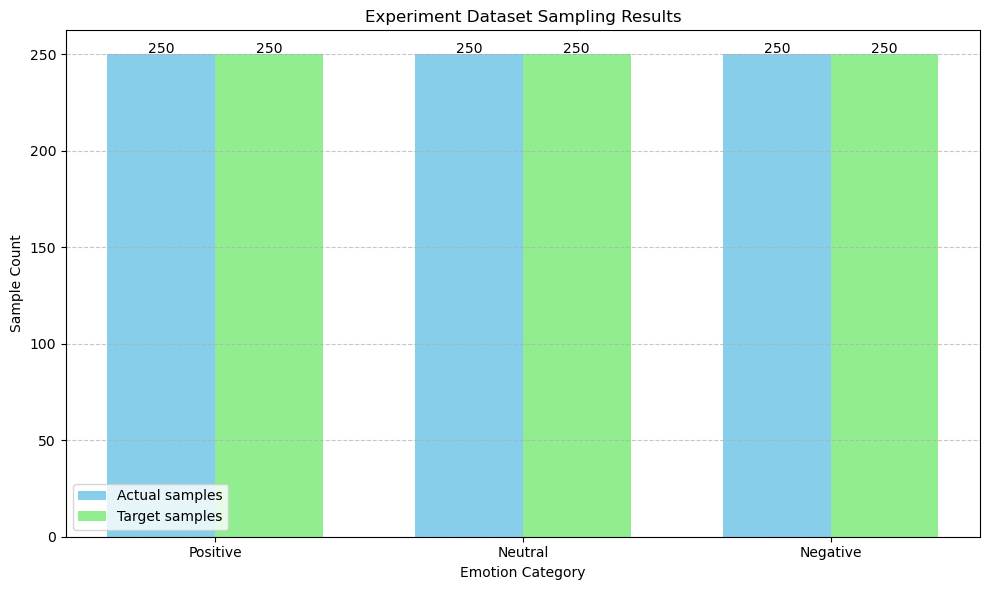

In [66]:
import os
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define data extraction function
def extract_balanced_samples(input_dir, output_base_dir, samples_per_category=100):
    """
    Extract a specified number of samples from each emotion category and save to new folders
    
    Parameters:
    input_dir: Input directory containing classified audio files
    output_base_dir: Base output directory
    samples_per_category: Number of samples to extract per category
    """
    # Ensure input directory exists
    if not os.path.exists(input_dir):
        print(f"Error: Input directory {input_dir} does not exist")
        return
        
    # Create output directory
    os.makedirs(output_base_dir, exist_ok=True)
    
    # Define categories and corresponding directory names
    categories = {
        'Positive': 'experiment_positive',
        'Neutral': 'experiment_neutral',
        'Negative': 'experiment_negative'
    }
    
    # Create output directory for each category
    for category, dir_name in categories.items():
        category_output_dir = os.path.join(output_base_dir, dir_name)
        os.makedirs(category_output_dir, exist_ok=True)
        print(f"Created directory: {category_output_dir}")
    
    # Collect files for each category
    category_files = {}
    for category in categories.keys():
        input_category_dir = os.path.join(input_dir, category.lower())
        if not os.path.exists(input_category_dir):
            print(f"Warning: Category directory {input_category_dir} does not exist")
            continue
            
        # Collect all audio files in this category
        files = []
        for root, _, filenames in os.walk(input_category_dir):
            for filename in filenames:
                if filename.endswith('.wav'):
                    files.append(os.path.join(root, filename))
        
        category_files[category] = files
        print(f"Found {len(files)} files in {category} category")
    
    # Extract samples and copy to new directories
    files_copied = {category: 0 for category in categories}
    for category, files in category_files.items():
        output_dir = os.path.join(output_base_dir, categories[category])
        
        if len(files) == 0:
            print(f"Warning: No files available for {category} category")
            continue
            
        # If there are not enough files, use all of them; otherwise sample randomly
        if len(files) <= samples_per_category:
            selected_files = files
            print(f"{category} category has fewer than {samples_per_category} files, using all {len(files)} files")
        else:
            selected_files = np.random.choice(files, samples_per_category, replace=False)
            print(f"Randomly selected {samples_per_category} files from {category} category")
        
        # Copy files to target directory
        for file_path in tqdm(selected_files, desc=f"Copying {category} files"):
            file_name = os.path.basename(file_path)
            dest_path = os.path.join(output_dir, file_name)
            
            try:
                shutil.copy2(file_path, dest_path)
                files_copied[category] += 1
            except Exception as e:
                print(f"Error copying file {file_path}: {str(e)}")
    
    # Print statistics
    print("\nSampling complete. Files copied per category:")
    for category, count in files_copied.items():
        print(f"{category}: {count}/{samples_per_category}")
    
    # Create metadata file
    metadata_file = os.path.join(output_base_dir, 'experiment_metadata.txt')
    with open(metadata_file, 'w') as f:
        f.write("Experiment Dataset Metadata\n")
        f.write("====================\n\n")
        f.write(f"Target samples per category: {samples_per_category}\n\n")
        
        f.write("Actual file count per emotion category:\n")
        for category, count in files_copied.items():
            f.write(f"{category}: {count}\n")
    
    print(f"\nMetadata saved to {metadata_file}")
    
    return files_copied

# Execute sampling
# Specify input directory (with classified audio files)
input_directory = "./processed_audio_data"

# Specify output directory (sampled files will be saved here)
output_directory = "./experiment_data"

# Number of samples to extract per category
samples_per_category = 250

# Execute sampling
result = extract_balanced_samples(input_directory, output_directory, samples_per_category)

# Plot sampling results
import matplotlib.pyplot as plt

# Prepare data
categories = list(result.keys())
counts = list(result.values())
target = [samples_per_category] * len(categories)

# Create bar chart
plt.figure(figsize=(10, 6))
x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, counts, width, label='Actual samples', color='skyblue')
plt.bar(x + width/2, target, width, label='Target samples', color='lightgreen')

plt.xlabel('Emotion Category')
plt.ylabel('Sample Count')
plt.title('Experiment Dataset Sampling Results')
plt.xticks(x, categories)
plt.legend()

# Add value labels
for i, v in enumerate(counts):
    plt.text(i - width/2, v + 1, str(v), ha='center')
    
for i, v in enumerate(target):
    plt.text(i + width/2, v + 1, str(v), ha='center')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()